<h2>NFDRS Version 4.0 Master Class</h2><br>
Series 1, 18 Jan 2022<br>
Series 2, 22 Feb 2022<br>
<hr>
<h2>Introduction to the Growing Season Index for Live Fuel Moistures</h2>



In [94]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import warnings
warnings.filterwarnings('ignore')

Step 1: Read the FW21 data file from FireFamily+, strip spaces from the column headings and format the date as a Pandas DateTime data type.  Note: This is a complete, HOURLY data file.

In [95]:
fwx = pd.read_csv("./Data/241513.fw21")
fwx.rename(columns=lambda x: x.strip(), inplace=True)
fwx['DateTime']=pd.to_datetime(fwx['DateTime'])
fwx.head()
#fwx

,DateTime,Temperature(F),RelativeHumidity(%),Precipitation(in),WindSpeed(mph),WindAzimuth(degrees),SolarRadiation(W/m2),SnowFlag,GustSpeed(mph),GustAzimuth(degrees)
0,2001-01-01 20:00:00+00:00,40.0,68.0,NaN,4.0,200.0,NaN,0,NaN,NaN
1,2001-01-02 20:00:00+00:00,26.0,89.0,NaN,1.0,223.0,NaN,0,NaN,NaN
2,2001-01-03 20:00:00+00:00,31.0,72.0,NaN,2.0,292.0,NaN,0,NaN,NaN
3,2001-01-04 20:00:00+00:00,48.0,48.0,NaN,2.0,217.0,NaN,0,NaN,NaN
4,2001-01-05 20:00:00+00:00,49.0,47.0,NaN,13.0,239.0,NaN,0,NaN,NaN


In [96]:
# Let's add some QA/QC here
fwx = fwx[fwx['Temperature(F)'] <= 110]

Step 2: EXPLORE - Let's make a plot the max, mean and min daily temperature

In [97]:
print(fwx.DateTime.min())
print(fwx.DateTime.max())

2001-01-01 20:00:00+00:00
2021-01-01 06:00:00+00:00


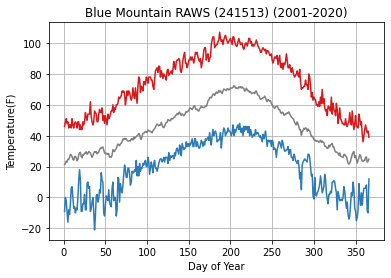

In [98]:
f,ax = plt.subplots()
fwx['Temperature(F)'].groupby(fwx.DateTime.dt.dayofyear).min().plot(ax=ax,color='#2c7bb6')
fwx['Temperature(F)'].groupby(fwx.DateTime.dt.dayofyear).mean().plot(ax=ax,color='grey')
fwx['Temperature(F)'].groupby(fwx.DateTime.dt.dayofyear).max().plot(ax=ax,color='#d7191c')
ax.set_xlabel("Day of Year")
ax.set_ylabel("Temperature(F)")
ax.set_title("Blue Mountain RAWS (241513) (2001-2020)")
plt.grid()

<AxesSubplot:ylabel='Frequency'>

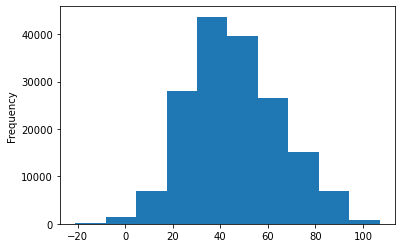

In [99]:
fwx['Temperature(F)'].plot.hist()

In [100]:
fwx[fwx['Temperature(F)'] > 110]

,DateTime,Temperature(F),RelativeHumidity(%),Precipitation(in),WindSpeed(mph),WindAzimuth(degrees),SolarRadiation(W/m2),SnowFlag,GustSpeed(mph),GustAzimuth(degrees)


Note about colors:  Many standard color palettes are hard for many people to see. I like this website that has good, colorblind friendly palettes.  You can steal these colors and use directly anywhere in Python: https://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=11

In [101]:
# You can use this line to limit the data including the data frame.  
# This line will make sure we don't include any data from 2022.
fwx = fwx[(fwx['DateTime'] <= '2021-12-31')]

Step 3: Let's calculate Photoperiod for our dataset....

In [102]:
# This function will calculate Photoperiod from Latitude and Day of Year

RADPERDAY = 0.017214
RADPERDEG = 0.01745329
MINDECL = -0.4092797
SECPERRAD = 13750.9871
DAYSOFF = 10.25

#Inputs: lat = Latitude in Degrees, yday is the day of the year.
#Returns: Daylength in seconds

def CalcDayl(lat,yday):
        # Daylength function from MT-CLIM */
        lat = lat * RADPERDEG
        if lat > 1.5707:
            lat = 1.5707
        if lat < -1.5707:
            lat = -1.5707
        coslat = cos(lat)
        sinlat = sin(lat)

        #* calculate cos and sin of declination */
        decl = MINDECL * cos((yday + DAYSOFF) * RADPERDAY)
        cosdecl = cos(decl)
        sindecl = sin(decl)
        cosegeom = coslat * cosdecl
        sinegeom = sinlat * sindecl
        coshss = -(sinegeom) / cosegeom
        if coshss < -1.0:
            coshss = -1.0  # 24-hr daylight */
        if coshss > 1.0:
            coshss = 1.0    # 0-hr daylight */
        hss = acos(coshss)                # hour angle at sunset (radians) */
        #* daylength (seconds) */
        return 2.0 * hss * SECPERRAD

In [103]:
# Test the CalcDayl function
CalcDayl(42.6,240) / 3600

13.145941694496848

In [104]:
# GSI Inputs are:
# Minimum Temperature (deg C)
# Vapor Pressure Deficit (Pascal)
# Daylength (Seconds)
# Running Total Precipitation (inches)

In [105]:
# Defaults for GSI are:
# Tmin: -2 to 5
# VPD: 900 to 4100
# Dayl: 36000 to 39600
#


In [106]:
# Compute and store the day of the year for use in calculating Daylength
fwx['JDay'] = fwx.DateTime.dt.dayofyear

In [107]:
# Loop through the dataframe and calcuate Daylength for each row
Lat = 42.6                               # Station Latitude in decimal degrees
Dayl = []                                # Create an empty list of data
for index, row in fwx.iterrows():  # Loop through the DataFrame.  Each interation pulls a 'row'
    jday = int(row.JDay)                 # Make sure to correct the data type
    Dayl.append(CalcDayl(Lat,jday))      # Calc Daylength and append to our list
fwx['Dayl'] = Dayl                 # Insert the list as a new column in the DataFrame

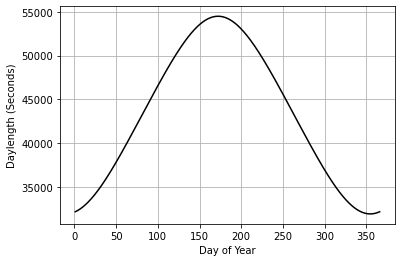

In [108]:
# Make a simple plot of Daylength. It doesn't change from year to year.
ax = fwx['Dayl'].groupby(fwx.DateTime.dt.dayofyear).mean().plot(color='black')
ax.set_xlabel("Day of Year")
ax.set_ylabel("Daylength (Seconds)")
plt.grid()

Step 4: Now let's compute VPDMax.  We need two functions to help us. 

In [109]:
# Function to calculate the Saturation Vapor Pressure for a given temperature.
# Note: Function converts internally from F to C.
def CalcVP(tempF):
    tmpC =  (tempF - 32.0) / 1.8
    vp = 610.7 * exp((17.38 * tmpC)/(239 + tmpC))
    return vp

# Calculate the VPD from RH and temperature
def CalcVPD(RH, TempF):
    vp = CalcVP(TempF)
    vpd = vp - (RH / 100) * vp
    if(vpd < 0.0):
        vpd = 0.0;
    return vpd

In [110]:
CalcVPD(50,75)

1481.4711094180602

In [111]:
# Use of resample requires us to set the DateTime as the Index
# This is a great reference for resample: 
# https://towardsdatascience.com/using-the-pandas-resample-function-a231144194c4
fwx_hourly = fwx.set_index('DateTime')

Tmin = pd.DataFrame({"Tmin": fwx_hourly['Temperature(F)'].resample('D').min()})  
Tmax = pd.DataFrame({"Tmax": fwx_hourly['Temperature(F)'].resample('D').max()})
Tavg = pd.DataFrame({"Tavg": fwx_hourly['Temperature(F)'].resample('D').mean()})
Dayl = pd.DataFrame({"Dayl": fwx_hourly['Dayl'].resample('D').mean()})
RHmin = pd.DataFrame({"RHmin": fwx_hourly['RelativeHumidity(%)'].resample('D').min()})
RHmax = pd.DataFrame({"RHmax": fwx_hourly['RelativeHumidity(%)'].resample('D').max()})
RHavg = pd.DataFrame({"RHavg": fwx_hourly['RelativeHumidity(%)'].resample('D').mean()})

In [112]:
fwx_daily = pd.concat([Tmax,Tmin,RHmax,RHmin,Dayl],axis=1)
fwx_daily['DateTime'] = fwx_daily.index
fwx_daily = fwx_daily.dropna()

In [113]:
# Loop through DataFrame and calculate VPD, just like before
VPD = []  # Empty Array
for index, row in fwx_daily.iterrows():
    temp = float(row.Tmax)
    rh = float(row.RHmin)
    VPD.append(CalcVPD(rh,temp) )
fwx_daily['VPDMax'] = VPD

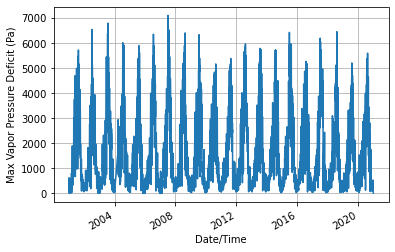

In [114]:
ax = fwx_daily.VPDMax.plot()
ax.set_xlabel("Date/Time")
ax.set_ylabel("Max Vapor Pressure Deficit (Pa)")
plt.grid()

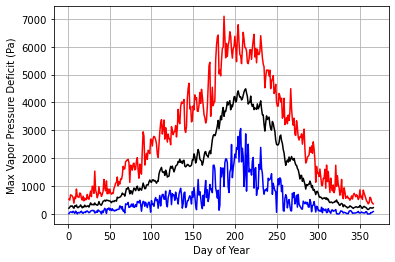

In [115]:
f,ax = plt.subplots()
fwx_daily.VPDMax.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(ax=ax,color='black')
fwx_daily.VPDMax.groupby(fwx_daily.DateTime.dt.dayofyear).min().plot(ax=ax,color='blue')
fwx_daily.VPDMax.groupby(fwx_daily.DateTime.dt.dayofyear).max().plot(ax=ax,color='red')
ax.set_xlabel("Day of Year")
ax.set_ylabel("Max Vapor Pressure Deficit (Pa)")
plt.grid()

Step 5: Finally, let's calculate one of the Indicator or Ramp functions for one of the variables.

In [116]:
fwx_daily['TminC'] =  (fwx_daily.Tmin - 32.0) * 5.0 / 9.0; # Convert Tmin from Fahrenheit to celcuius

In [117]:
# Here is an easy way to look for crazy values.  Let's look at the days in the dataset that have TempF greater than 120F
#fwx_daily[fwx_daily['Tmax'] > 120]

Here is a good article on ways to drop data from the DataFrame
https://www.datasciencemadesimple.com/drop-delete-rows-conditions-python-pandas/

In [118]:
# GSI indicator/ramp function
def Ind(Var,Low,Up):
    # Make sure all the input variables are numbers
    Var = float(Var)
    Low = float(Low)
    Up = float(Up)
    if(Up == Low):  # Upper (Up) and Lower (Low) can't be the same
        return 0
    if( Var < Low):  # If the variables is less than the lower limit, return 0
        return 0
    elif(Var > Up):  # If the variables is greater than the upper limit, return 1
        return 1
    else:            # If the variables is between the lower and upper limits, return the proportion
        return (Var - Low) / (Up - Low)

In [119]:
# Test the GSI Indicator / Ramp Function
Ind(-1.9,-2,5)

0.0142857142857143

In [120]:
# Test the indicator function over a range of temperature
t = [-3,-2,-1,0,1,2,3,4,5,6,7]
ind = []
for v in t:
    ind.append(Ind(v,-2,5))

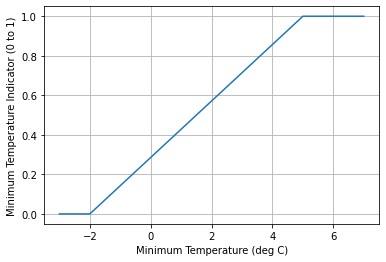

In [121]:
f,ax = plt.subplots()
ax.plot(t,ind)
ax.set_xlabel("Minimum Temperature (deg C)")
ax.set_ylabel("Minimum Temperature Indicator (0 to 1)")
plt.grid()

In [122]:
TminInd = []  # Empty Array
TminLow = -2        # Lower limit for Minimum Temperature (-2degC by default)
TminUp = 5          # Upper limit for Minimum Temperature (5degC by default)
for index, row in fwx_daily.iterrows():
    temp = float(row.TminC)
    TminInd.append(Ind(temp,TminLow,TminUp))
fwx_daily['TminInd'] = TminInd

In [123]:
# The 'Pythonic' way of doing the above
fwx_daily['TminInd'] = fwx_daily.apply(lambda row: Ind(row['TminC'],TminLow,TminUp),axis=1)

Text(0, 0.5, 'Minimum Temperature Indicator (0 to 1)')

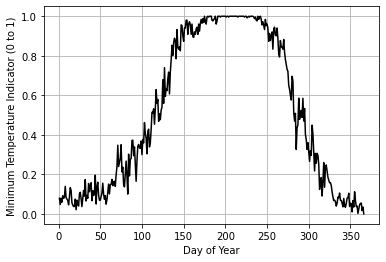

In [124]:
f,ax = plt.subplots()
fwx_daily.TminInd.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(color='black')
plt.grid()
ax.set_xlabel("Day of Year")
ax.set_ylabel("Minimum Temperature Indicator (0 to 1)")

In [ ]:
Met417201['RunSumPrcp'] = Met417201['Rain'].rolling(45).sum()

 for index, row in Temp.iterrows():
        itmin = GetTminInd(fToc(row.MinT),BestParams[0],BestParams[1])
        ivpd = GetVPDInd(row.VPDM,BestParams[2],BestParams[3])
        idayl = GetDaylInd(row.Dayl,BestParams[4],BestParams[5])
        iprcp = GetTminInd(row.RunSumPrcp,BestParams[6],BestParams[7])
        igsi = itmin*ivpd*idayl
        igsip = itmin*ivpd*idayl*iprcp
        iGSI.append(igsi)
        iGSIPrcp.append(igsip)
    
    # Compute the running average
    # 3 variable GSI
    Temp['iGSI'] = iGSI
    Temp['GSI'] = Temp['iGSI'].rolling(BestParams[8]).mean()
    # Rescale using 99th percentile GSI
    Temp['GSI'] = Temp['GSI'] / Temp['GSI'].quantile(0.99)
    
    # 4 variable GSI
    Temp['iGSIPrcp'] = iGSIPrcp
    Temp['GSIP'] = Temp['iGSIPrcp'].rolling(BestParams[8]).mean()
    # Rescale using 99th percentile GSI
    Temp['GSIP'] = Temp['GSIP'] / Temp['GSIP'].quantile(0.99)

    # LFM Calcs here
    if GUThresh >= 1:
        return([-999.9,-999.9,999.9,Temp])
    m = (LFMMax - LFMMin) / (1 - GUThresh)
    b = LFMMax - m
    for index, row in Temp.iterrows():
        # 3 variable GSI LFM 
        if(row.GSI > GUThresh):
            LW = m*row.GSI + b
        else:
            LW = LFMMin
        # 4 variable GSI LFM
        if(row.GSIP > GUThresh):
            LWP = m*row.GSIP + b
        else:
            LWP = LFMMin
        LFMWood.append(LW)
        LFMWoodP.append(LWP)